<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 02 - Classification and Clustering

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’. 

In [1]:
import os
import re
import string
import nltk
import random
import gensim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br> 
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Drive

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### NLTK Downloads

In [3]:
# Only run this once, they will be downloaded.
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [4]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [5]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.8.3


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [7]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['ReviewType'] == 'Positive', 'P', 'N')

    data['Descriptor'] = corpus_df['Genre'] + '_' + \
                         corpus_df['MovieTitle'] + '_' + \
                         review + '_' + \
                         corpus_df['FileName'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['FileName'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()    

def remove_tags(text):    
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))
        
    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))
        
    return result
    
def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
    data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
    data['is_action'] = data.index.isin(action_doc_ids)
    
def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

def clean_doc(doc): 
    #split document into individual words
    tokens = doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf = TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix = Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix = pd.DataFrame(TFIDF_matrix.toarray(), 
                          columns=Tfidf.get_feature_names(), 
                          index=titles)
    return matrix #,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE = LabelEncoder()
    LE.fit(variable)
    Label1 = LE.transform(variable)
    OHE = OneHotEncoder()
    labels = OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

## Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix 
1. Latent Semantic Analysis 
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

In [8]:
def create_gensim_lsa_model(doc_clean,
                            number_of_topics,
                            words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, 
                        num_topics=number_of_topics, 
                        id2word = dictionary)  # train model
    
    print(lsamodel.print_topics(num_topics=number_of_topics, 
                                num_words=words))
    
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel, dictionary, index

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
            
def create_gensim_lda_model(doc_clean,
                            number_of_topics,
                            words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix, 
                        num_topics=number_of_topics, 
                        id2word = dictionary)
    
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, 
                                num_words=words))
    
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    
    return ldamodel, dictionary, index, doc_term_matrix

def lda(tfidf_matrix, terms, topics=3, num_words=10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)
    
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, 
                         size=100, 
                         window=5, 
                         min_count=1, 
                         workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]

    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors = {}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec = model_w2v.wv[i]
        w2v_vectors[i] = temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    
    print(w2v_df)
    return w2v_df

## Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest

In [9]:
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state=89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary = {'Doc Name': titles, 
                  'Cluster': clusters,  
                  'Text': final_processed_text}

    frame = pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title = {}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title, clusters, frame

def classifiers(x, y, model_type, cv = 3):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions) 
    return accy

## Visualization Utility Functions

In [10]:
def plot_lsa(number_of_topics, words):

    model, dictionary, index = create_gensim_lsa_model(processed_text,
                                                       number_of_topics,
                                                       words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_tfidf_matrix(cluster_title,
                      clusters,
                      TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, 
              dissimilarity="precomputed", 
              random_state=1)

    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown',
                      4: 'firebrick', 5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.  
    cluster_dict = cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

## Loading the Class Corpus

In [11]:
#read in class corpus csv into python
data = pd.read_csv(r'ClassCorpus_V2.csv')

In [12]:
data.head()

,FileName,StudentName,Genre,ReviewType,MovieTitle,MovieReview
0,KHS_Doc1_TheRing,KHS,Horror,Negative,The Ring,"Described as a drama, horror and mystery, The ..."
1,KHS_Doc2_TheRing,KHS,Horror,Negative,The Ring,"I hated it, but I grant that it does tap into..."
2,KHS_Doc3_TheRing,KHS,Horror,Negative,The Ring,Ehren Kruger (no relation to Freddy) showed a ...
3,KHS_Doc4_TheRing,KHS,Horror,Negative,The Ring,Not all arthouse thrillers are destined to be ...
4,KHS_Doc5_TheRing,KHS,Horror,Negative,The Ring,Rarely has a more serious effort produced a le...


In [13]:

#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['MovieReview'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]

In [14]:
titles = data['FileName'].tolist()
processed_text = data['processed_text'].tolist()

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

## Exploratory Data Analysis

In [15]:
CORPUS_PATH = 'ClassCorpus_V2.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

In [16]:
corpus_df.head()

,StudentName,Genre,ReviewType,MovieTitle,MovieReview,Descriptor,Doc_ID
FileName,,,,,,,
SSM_Doc10_BabyDriver,SSM,Action,Negative,Baby Driver,"Getaway driver Baby (Ansel Elgort, The Diverge...",Action_Baby Driver_N_SSM_Doc10_BabyDriver,SSM_Doc10_BabyDriver
SSM_Doc6_BabyDriver,SSM,Action,Negative,Baby Driver,BABY DRIVER is quite frustrating because the d...,Action_Baby Driver_N_SSM_Doc6_BabyDriver,SSM_Doc6_BabyDriver
SSM_Doc7_BabyDriver,SSM,Action,Negative,Baby Driver,"The star, ace getaway driver Baby (Ansel Elgor...",Action_Baby Driver_N_SSM_Doc7_BabyDriver,SSM_Doc7_BabyDriver
SSM_Doc8_BabyDriver,SSM,Action,Negative,Baby Driver,Edgar Wright is back in action movie mode for ...,Action_Baby Driver_N_SSM_Doc8_BabyDriver,SSM_Doc8_BabyDriver
SSM_Doc9_BabyDriver,SSM,Action,Negative,Baby Driver,"Thanks to an error in judgment, Baby (the main...",Action_Baby Driver_N_SSM_Doc9_BabyDriver,SSM_Doc9_BabyDriver


In [17]:
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.MovieReview)]

In [18]:
corpus_df.shape

(190, 7)

In [19]:
corpus_df.head().T

FileName,SSM_Doc10_BabyDriver,SSM_Doc6_BabyDriver,SSM_Doc7_BabyDriver,SSM_Doc8_BabyDriver,SSM_Doc9_BabyDriver
StudentName,SSM,SSM,SSM,SSM,SSM
Genre,Action,Action,Action,Action,Action
ReviewType,Negative,Negative,Negative,Negative,Negative
MovieTitle,Baby Driver,Baby Driver,Baby Driver,Baby Driver,Baby Driver
MovieReview,"Getaway driver Baby (Ansel Elgort, The Diverge...",BABY DRIVER is quite frustrating because the d...,"The star, ace getaway driver Baby (Ansel Elgor...",Edgar Wright is back in action movie mode for ...,"Thanks to an error in judgment, Baby (the main..."
Descriptor,Action_Baby Driver_N_SSM_Doc10_BabyDriver,Action_Baby Driver_N_SSM_Doc6_BabyDriver,Action_Baby Driver_N_SSM_Doc7_BabyDriver,Action_Baby Driver_N_SSM_Doc8_BabyDriver,Action_Baby Driver_N_SSM_Doc9_BabyDriver
Doc_ID,SSM_Doc10_BabyDriver,SSM_Doc6_BabyDriver,SSM_Doc7_BabyDriver,SSM_Doc8_BabyDriver,SSM_Doc9_BabyDriver


In [20]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Index: 190 entries, SSM_Doc10_BabyDriver to AJD_Doc5_TheMatrixResurrections
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StudentName  190 non-null    object
 1   Genre        190 non-null    object
 2   ReviewType   190 non-null    object
 3   MovieTitle   190 non-null    object
 4   MovieReview  190 non-null    object
 5   Descriptor   190 non-null    object
 6   Doc_ID       190 non-null    object
dtypes: object(7)
memory usage: 11.9+ KB
None


## Latent Semantic Analysis - Research Number of Topics and Number of Words

### Plotting 2 topics and 10 words

[(0, '0.326*"movie" + 0.190*"films" + 0.169*"story" + 0.163*"first" + 0.131*"movies" + 0.122*"characters" + 0.119*"matrix" + 0.119*"action" + 0.110*"character" + 0.109*"makes"'), (1, '0.663*"cruella" + 0.192*"baroness" + 0.168*"estella" + -0.153*"matrix" + 0.142*"cruellas" + -0.138*"movie" + 0.133*"villain" + 0.131*"character" + 0.128*"fashion" + 0.110*"story"')]


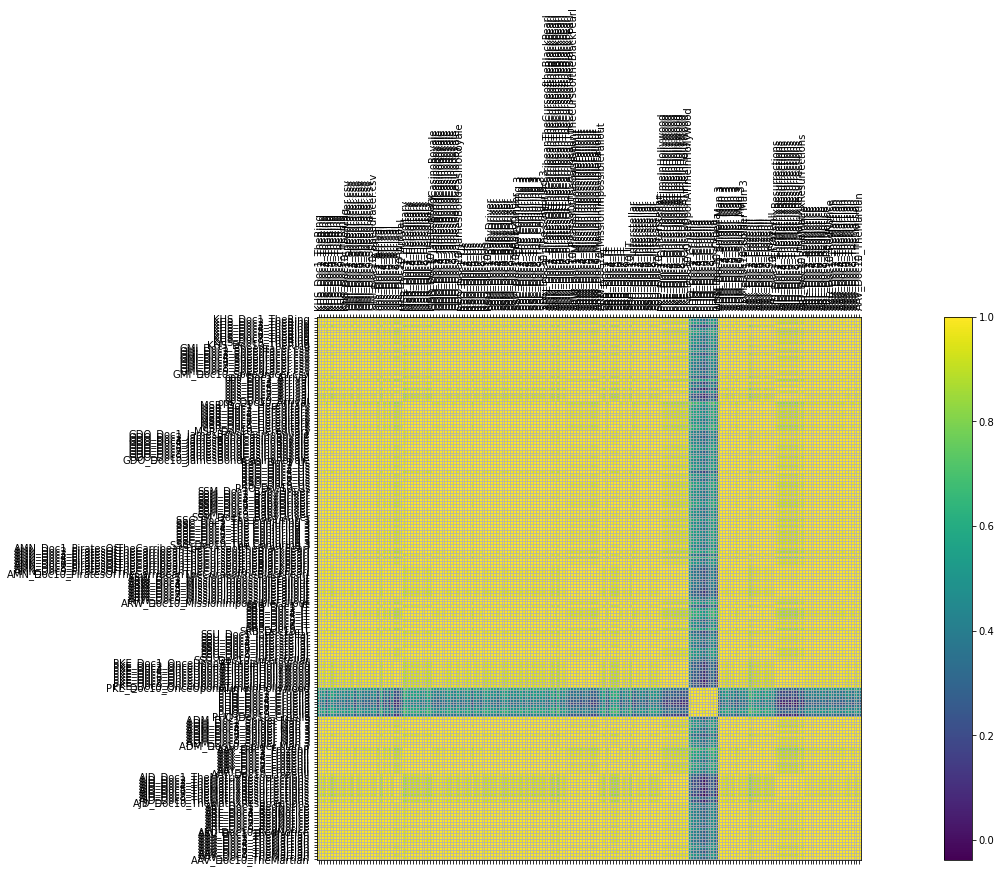

In [21]:
model_2topic_10words = plot_lsa(2, 10)

### Plotting 6 topics and 10 words

[(0, '-0.326*"movie" + -0.190*"films" + -0.169*"story" + -0.163*"first" + -0.131*"movies" + -0.122*"characters" + -0.119*"matrix" + -0.119*"action" + -0.110*"character" + -0.109*"makes"'), (1, '-0.663*"cruella" + -0.192*"baroness" + -0.168*"estella" + 0.153*"matrix" + -0.142*"cruellas" + 0.138*"movie" + -0.133*"villain" + -0.131*"character" + -0.128*"fashion" + -0.110*"story"'), (2, '0.433*"matrix" + -0.359*"tarantino" + -0.348*"hollywood" + -0.185*"cliff" + 0.179*"resurrections" + -0.147*"tarantinos" + -0.141*"dalton" + 0.135*"first" + 0.125*"action" + -0.116*"dicaprio"'), (3, '-0.490*"matrix" + 0.227*"casino" + 0.219*"royale" + -0.200*"resurrections" + -0.179*"tarantino" + -0.167*"hollywood" + 0.145*"mission" + 0.131*"craig" + -0.121*"cruella" + -0.119*"movie"'), (4, '0.258*"movie" + -0.212*"action" + -0.205*"cruise" + -0.200*"mission" + -0.184*"impossible" + 0.182*"horror" + -0.170*"tarantino" + -0.161*"fallout" + -0.155*"hollywood" + -0.145*"matrix"'), (5, '-0.359*"casino" + -0.346

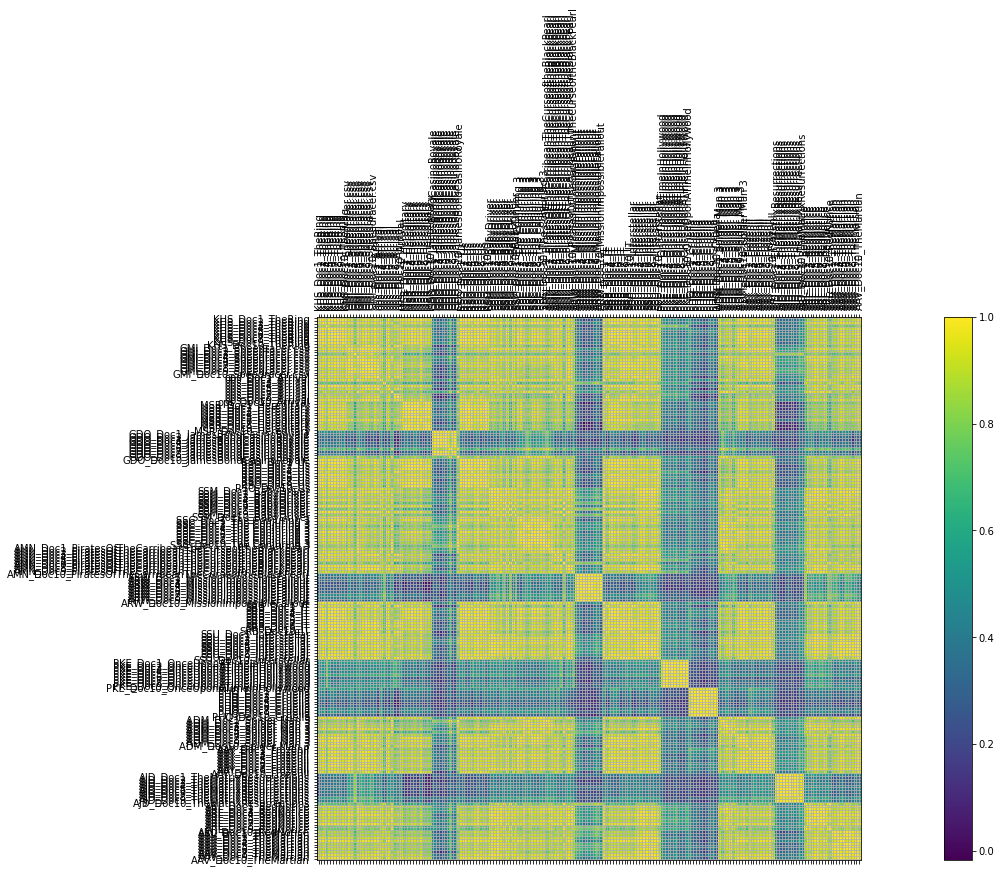

In [22]:
model_6topic_10words = plot_lsa(6, 10)

### Plotting 20 topics and 10 words

[(0, '-0.326*"movie" + -0.190*"films" + -0.169*"story" + -0.163*"first" + -0.131*"movies" + -0.122*"characters" + -0.119*"matrix" + -0.119*"action" + -0.110*"character" + -0.109*"makes"'), (1, '0.663*"cruella" + 0.192*"baroness" + 0.168*"estella" + -0.153*"matrix" + 0.142*"cruellas" + -0.138*"movie" + 0.133*"villain" + 0.131*"character" + 0.128*"fashion" + 0.110*"story"'), (2, '-0.433*"matrix" + 0.359*"tarantino" + 0.347*"hollywood" + 0.185*"cliff" + -0.179*"resurrections" + 0.147*"tarantinos" + 0.141*"dalton" + -0.135*"first" + -0.125*"action" + 0.116*"dicaprio"'), (3, '-0.490*"matrix" + 0.227*"casino" + 0.219*"royale" + -0.201*"resurrections" + -0.179*"tarantino" + -0.167*"hollywood" + 0.145*"mission" + 0.132*"craig" + -0.121*"cruella" + -0.119*"movie"'), (4, '-0.258*"movie" + 0.212*"action" + 0.205*"cruise" + 0.199*"mission" + 0.184*"impossible" + -0.182*"horror" + 0.170*"tarantino" + 0.161*"fallout" + 0.155*"hollywood" + 0.145*"matrix"'), (5, '0.359*"casino" + 0.346*"royale" + -0.2

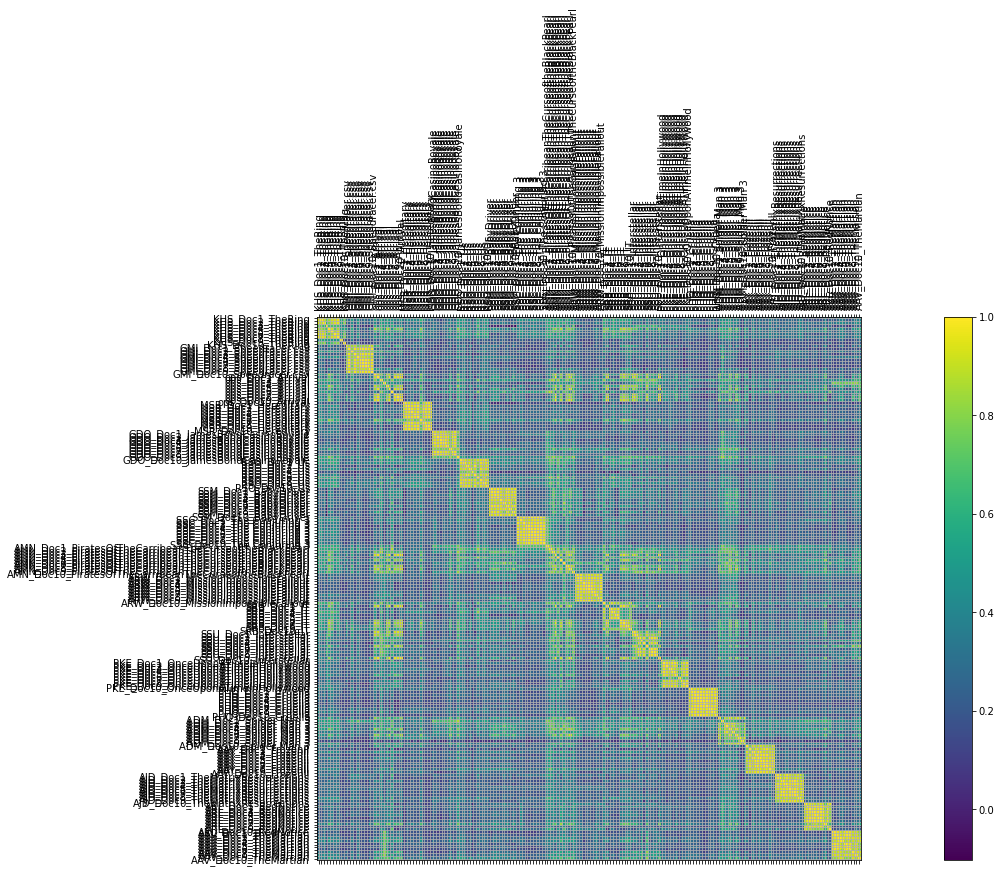

In [23]:
model_20topic_10words = plot_lsa(20, 10)

### Compare LSA Model Coherence

In [24]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, 
                                         dictionary=dictionary, 
                                         texts=processed_text, 
                                         coherence='c_v')
    
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence = {'6 topic 10 words':coherence_values[0],
             '2 topic 10 words': coherence_values[1],
             '20 topic 10 words':coherence_values[2]}   

print(coherence)

[(0, '-0.326*"movie" + -0.190*"films" + -0.169*"story" + -0.163*"first" + -0.131*"movies" + -0.122*"characters" + -0.119*"matrix" + -0.119*"action" + -0.110*"character" + -0.109*"makes"'), (1, '-0.663*"cruella" + -0.192*"baroness" + -0.168*"estella" + 0.153*"matrix" + -0.142*"cruellas" + 0.138*"movie" + -0.133*"villain" + -0.131*"character" + -0.128*"fashion" + -0.110*"story"'), (2, '0.433*"matrix" + -0.359*"tarantino" + -0.347*"hollywood" + -0.185*"cliff" + 0.179*"resurrections" + -0.147*"tarantinos" + -0.141*"dalton" + 0.135*"first" + 0.125*"action" + -0.116*"dicaprio"'), (3, '0.490*"matrix" + -0.227*"casino" + -0.219*"royale" + 0.200*"resurrections" + 0.179*"tarantino" + 0.167*"hollywood" + -0.145*"mission" + -0.132*"craig" + 0.121*"cruella" + 0.119*"movie"'), (4, '0.258*"movie" + -0.212*"action" + -0.205*"cruise" + -0.200*"mission" + -0.184*"impossible" + 0.182*"horror" + -0.170*"tarantino" + -0.161*"fallout" + -0.155*"hollywood" + -0.145*"matrix"'), (5, '0.359*"casino" + 0.346*"ro

## Latent Dirichlet Allocation - Research Number of Topics and Number of Words

In [25]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics = 6
words = 10
#####################################

[(0, '0.004*"movie" + 0.004*"films" + 0.003*"cruella" + 0.003*"action" + 0.003*"first" + 0.003*"movies" + 0.002*"never" + 0.002*"would" + 0.002*"character" + 0.002*"scene"'), (1, '0.004*"movie" + 0.004*"films" + 0.003*"movies" + 0.003*"character" + 0.002*"story" + 0.002*"first" + 0.002*"something" + 0.002*"characters" + 0.002*"frozen" + 0.002*"doesnt"'), (2, '0.006*"movie" + 0.003*"story" + 0.003*"films" + 0.003*"movies" + 0.002*"people" + 0.002*"could" + 0.002*"makes" + 0.002*"characters" + 0.002*"little" + 0.002*"first"'), (3, '0.008*"movie" + 0.004*"films" + 0.004*"first" + 0.003*"action" + 0.003*"story" + 0.003*"movies" + 0.003*"never" + 0.003*"matrix" + 0.002*"hollywood" + 0.002*"makes"'), (4, '0.006*"movie" + 0.004*"story" + 0.003*"films" + 0.003*"first" + 0.003*"world" + 0.003*"characters" + 0.003*"horror" + 0.002*"still" + 0.002*"matrix" + 0.002*"character"'), (5, '0.006*"movie" + 0.004*"story" + 0.004*"first" + 0.003*"films" + 0.003*"action" + 0.003*"characters" + 0.002*"makes

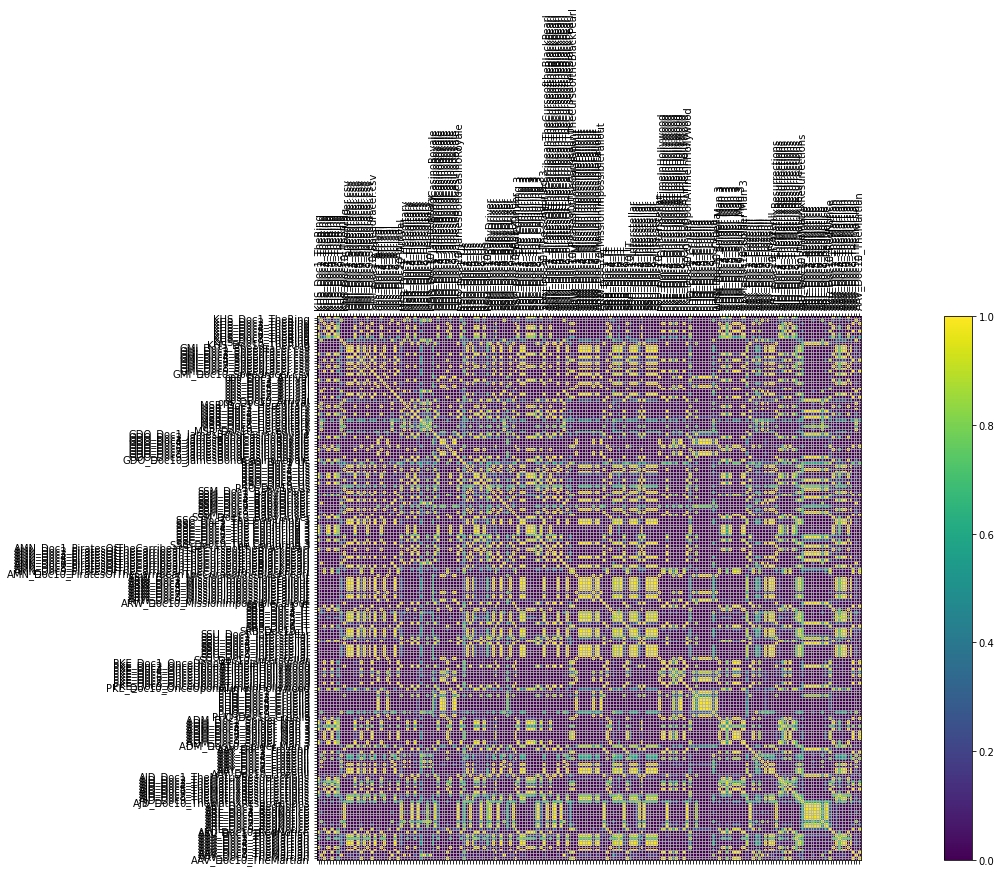

In [26]:
model2, dictionary2, index2, doctermmatrix2 = create_gensim_lda_model(processed_text,
                                                                      number_of_topics,
                                                                      words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

### Compare LDA Model Coherence

In [27]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    ldamodel, dictionary,index, matrix = create_gensim_lda_model(processed_text,
                                                                 t,
                                                                 10)

    coherence_model_lda = CoherenceModel(model=ldamodel, 
                                         dictionary=dictionary, 
                                         texts=processed_text, 
                                         coherence='c_v')
                                         
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    
coherence = {'6 topic 10 words':coherence_values[0],
             '2 topic 10 words': coherence_values[1],
             '20 topic 10 words':coherence_values[2]}   

print(coherence)

[(0, '0.009*"movie" + 0.003*"story" + 0.003*"movies" + 0.003*"makes" + 0.003*"films" + 0.002*"family" + 0.002*"character" + 0.002*"action" + 0.002*"characters" + 0.002*"speed"'), (1, '0.004*"movie" + 0.004*"films" + 0.003*"story" + 0.003*"something" + 0.003*"first" + 0.002*"horror" + 0.002*"frozen" + 0.002*"characters" + 0.002*"family" + 0.002*"theres"'), (2, '0.006*"movie" + 0.003*"films" + 0.003*"matrix" + 0.003*"action" + 0.003*"story" + 0.002*"world" + 0.002*"first" + 0.002*"movies" + 0.002*"character" + 0.002*"would"'), (3, '0.008*"movie" + 0.003*"story" + 0.003*"characters" + 0.003*"first" + 0.003*"movies" + 0.002*"world" + 0.002*"films" + 0.002*"people" + 0.002*"action" + 0.002*"character"'), (4, '0.004*"story" + 0.004*"movie" + 0.003*"films" + 0.003*"first" + 0.002*"cruella" + 0.002*"movies" + 0.002*"franchise" + 0.002*"never" + 0.002*"matrix" + 0.002*"character"'), (5, '0.005*"films" + 0.005*"movie" + 0.004*"first" + 0.003*"action" + 0.003*"theres" + 0.003*"movies" + 0.003*"wo

## NLP Supervised and Unsupervised Learning Methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

## Cluster Model Research: KMeans, SVM, Logistic, Naive Bayes, Randomforest

### Generate TF-IDF For Analysis

In [28]:
tfidf_matrix = tfidf(final_processed_text, 
                     titles, 
                     ngram_range = (1,1))

### KMeans Clustering

<div class="alert alert-block alert-success">
    <b>sklearn.cluster.KMeans</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br><br>
<b>KMeans Default Parameters</b>:<br>
    class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    </div>

In [29]:
cluster_title, clusters, k_means_df = k_means(titles, 
                                              tfidf_matrix, 
                                              k=20)

### Access Each Cluster - Changing Dictionary KeyValue from 0 to k

In [30]:
cluster_title[3]

['PHQ_Doc1_Cruella',
 'PHQ_Doc2_Cruella',
 'PHQ_Doc3_Cruella',
 'PHQ_Doc4_Cruella',
 'PHQ_Doc5_Cruella',
 'PHQ_Doc6_Cruella',
 'PHQ_Doc7_Cruella',
 'PHQ_Doc8_Cruella',
 'PHQ_Doc9_Cruella',
 'PHQ_Doc10_Cruella']

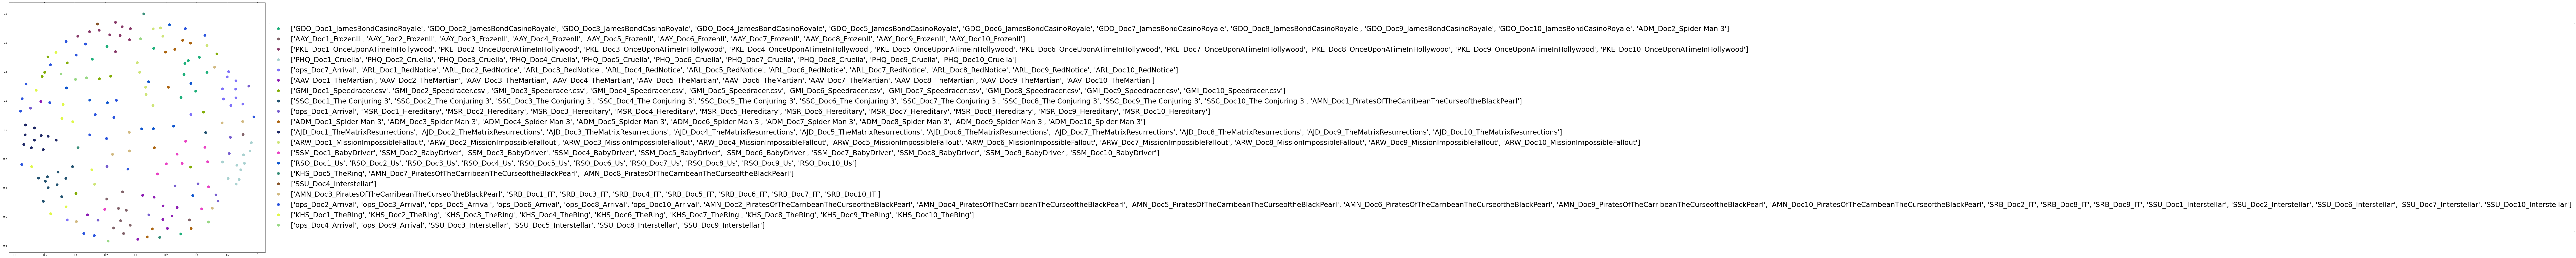

In [31]:
plot_tfidf_matrix(cluster_title,
                  clusters,
                  tfidf_matrix)

### Generate Labels for Supervised Learning Models

In [32]:
labels = data['ReviewType'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

0      0
1      0
2      0
3      0
4      0
      ..
185    0
186    0
187    0
188    0
189    0
Name: ReviewType, Length: 190, dtype: int64


### Support Vector Machines 

<div class="alert alert-block alert-success">
    <b>Support vector machines (SVMs)</b>:<br> 
https://scikit-learn.org/stable/modules/svm.html<br><br>
    Set of supervised learning methods used for classification, regression and outliers detection
    </div>

In [33]:
classifiers(tfidf_matrix, labels, 'svm')

svm


0.42857142857142855

### Logistic Regression Model 

<div class="alert alert-block alert-success">
    <b>sklearn.linear_model.LogisticRegression</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br><br>
<b>Logistic Regression Default Parameters</b>:<br>
    class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
    </div>

In [34]:
classifiers(tfidf_matrix, labels, 'logistic')

logistic


0.42857142857142855

### Naive Bayes

<div class="alert alert-block alert-success">
    <b>Naive Bayes</b>:<br> 
https://scikit-learn.org/stable/modules/naive_bayes.html<br><br>
    Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
    </div>

In [35]:
classifiers(tfidf_matrix, labels, 'naive_bayes')

naive_bayes


0.42857142857142855

### Random Forest

<div class="alert alert-block alert-success">
    <b>sklearn.ensemble.RandomForestClassifier</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br><br>
<b>RandomForest Classifier Default Parameters</b>:<br>
    class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    </div>

In [36]:
classifiers(tfidf_matrix, labels, 'randomforest')

randomforest


0.5396825396825397